# Project 3 : 2-EDA

## Problem statement

> Create the model to predict where the given post came from between cat and dog post

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Import Data from step 1

In [2]:
df_cat = pd.read_csv('data/cat_all.csv')
df_dog = pd.read_csv('data/dog_all.csv')
df_cat.shape, df_dog.shape

((5000, 2), (4999, 2))

In [3]:
df_cat.head()

,subreddit,title
0,cat,🐱
1,cat,The “how is it only Wednesday?!” mood - 😄 (OC)
2,cat,The Most Wonderful Time Of Year
3,cat,My grumpy boy doesn’t like being cuddled.
4,cat,If I fits it sits!


In [4]:
df_dog.head()

,subreddit,title
0,DOG,"Dog got quilled by porcupine, now has cellulit..."
1,DOG,Moved to a new house with a significantly bigg...
2,DOG,PLEASE HELP THESE DOGS! 🙏🏻❤️🥹
3,DOG,lil tongue poking out
4,DOG,via: @agea_santos


### EDA

#### Check subreddit category

In [5]:
set(df_cat['subreddit']), set(df_dog['subreddit'])

({'cat',
  'u_-Tux-cat-',
  'u_Accomplished-Cat-167',
  'u_Accomplished-Cat-619',
  'u_Advanced-Cat-876',
  'u_Adventurous-Cat-3616',
  'u_Affectionate-Cat-873',
  'u_Aggravating-Cat-8346',
  'u_Alternative-Cat-4173',
  'u_Apprehensive-Cat-709',
  'u_Available-Cat-7440',
  'u_Background-Cat-1512',
  'u_Beneficial-Cat-7203',
  'u_Big-Cat-5589',
  'u_Brilliant-Cat-1588',
  'u_Brilliant-Cat-6096',
  'u_Carl-the-reddit-cat',
  'u_Coder-Cat',
  'u_Comfortable-Cat-9396',
  'u_Competitive-Cat-7134',
  'u_Creepy-Cat-8796',
  'u_Cute-Sissy-Cat',
  'u_Dull-Cat-2998',
  'u_Eastern-Cat-1199',
  'u_Eastern-Cat-523',
  'u_Educational-Cat-7560',
  'u_Effective-Cat-4210',
  'u_Electrical-Cat-4725',
  'u_Embarrassed-Cat-3071',
  'u_Emotional-Cat-4336',
  'u_Euphoric-Cat-7461',
  'u_Excellent-Cat-7021',
  'u_Exciting-Cat-4606',
  'u_Far-Cat-6124',
  'u_Flimsy-Cat-6555',
  'u_Fun-Cat-3028',
  'u_Glass-Cat-66',
  'u_Gloomy-Cat-735',
  'u_Gullible-Cat-2299',
  'u_Hairy-Cat-2754',
  'u_Hefty-Cat-868',
  'u_

#### Remove unwant subreddit category

In [6]:
df_cat = df_cat[df_cat['subreddit']=='cat']
df_dog = df_dog[df_dog['subreddit']=='DOG']
df_cat.shape, df_dog.shape

((4471, 2), (4568, 2))

### Looking for any duplicates title

In [7]:
df_cat[df_cat.duplicated(['title'])]
# got this from https://www.statology.org/pandas-find-duplicates/

,subreddit,title
13,cat,beatiful cats
58,cat,my king of the jungle🤭😍
71,cat,This time it is it from the left hug
286,cat,Call me crazy but what if cats know we see the...
291,cat,Sunday mood
...,...,...
4897,cat,"God has entered into my body, as a Ghost body!..."
4924,cat,Big chomp
4928,cat,Would you squeeze my cheeks?
4952,cat,Big chomp


In [8]:
df_dog[df_dog.duplicated(['title'])]

,subreddit,title
89,DOG,Humans being Heros | by u/tarikdz5
155,DOG,"God entered into my body, like an angelic fire..."
233,DOG,Today is Piper's gotcha day 😍💕
412,DOG,50% off Discount on Pet Memorial Picture Frame...
539,DOG,What is he dreaming about?
...,...,...
4930,DOG,"Age progression of my sweet Jackabee, Bailey ❤️"
4955,DOG,What should I do?
4961,DOG,dogo
4982,DOG,Sleepy doggo


#### Remove duplicates

In [9]:
df_cat.drop_duplicates(subset="title", keep=False, inplace=True)
df_dog.drop_duplicates(subset="title", keep=False, inplace=True)
df_cat.shape, df_dog.shape
# got this from https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

((4121, 2), (4301, 2))

### Until now we have data left around 4,000 posts for each category

### Distribution of post lengths

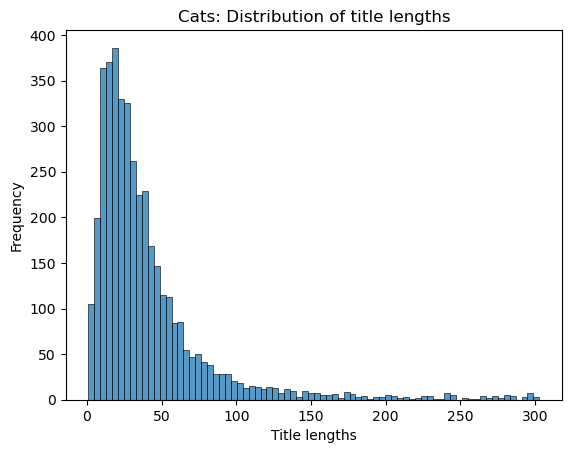

In [10]:
df_cat['title_length'] = df_cat['title'].map(lambda x: len(x))
sns.histplot(df_cat['title_length']).set(title='Cats: Distribution of title lengths', ylabel='Frequency', xlabel='Title lengths');

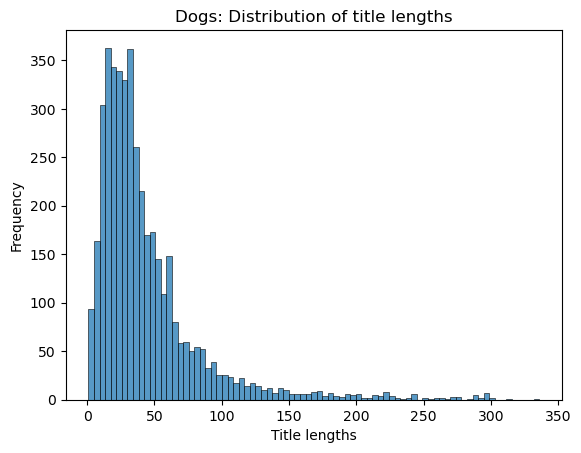

In [11]:
df_dog['title_length'] = df_dog['title'].map(lambda x: len(x))
sns.histplot(df_dog['title_length']).set(title='Dogs: Distribution of title lengths', ylabel='Frequency', xlabel='Title lengths');

In [32]:
df_cat.describe()

,title_length
count,4121.000000
mean,40.820432
std,42.687494
min,1.000000
25%,16.000000
50%,28.000000
75%,48.000000
max,303.000000


In [33]:
df_dog.describe()

,title_length
count,4301.000000
mean,44.527552
std,42.271855
min,1.000000
25%,19.000000
50%,33.000000
75%,53.000000
max,336.000000


#### > Dog posts have longer post lengths than cats.

## Word Counts by Vectorize the text

### Cats most common words

In [41]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_cat['title'])
status_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(status_cvec.toarray(), columns=cvec.get_feature_names_out())

In [42]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

cat          1251
cats          265
like          166
cute          146
love          135
little        133
just          130
kitten        126
new           118
kitty         116
baby          107
help           89
time           81
breed          77
christmas      76
dtype: int64

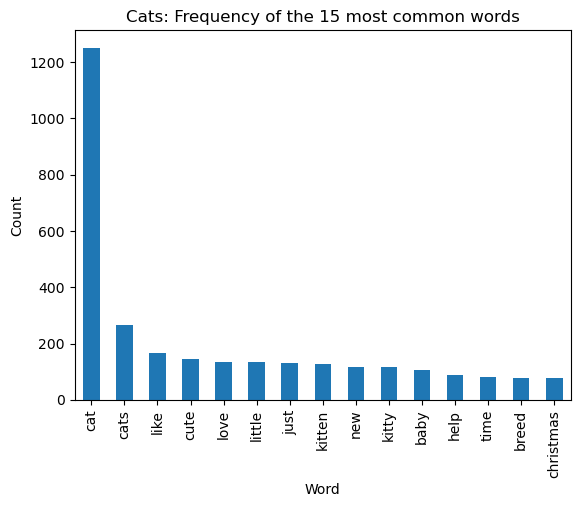

In [47]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most common words')
plt.xlabel('Word')
plt.ylabel('Count');

### Dogs most common words

In [43]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_dog['title'])
status_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(status_cvec.toarray(), columns=cvec.get_feature_names_out())

In [44]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

dog       1234
dogs       267
help       178
puppy      161
breed      152
just       143
cute       143
old        137
little     133
new        124
know       124
love       118
like       113
best       108
boy        106
dtype: int64

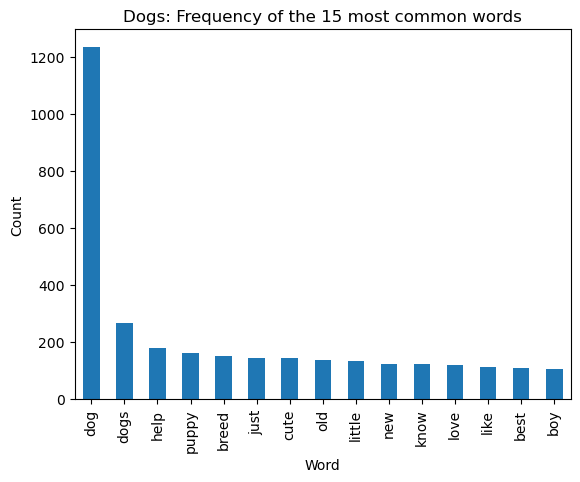

In [48]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most common words')
plt.xlabel('Word')
plt.ylabel('Count');

### Most common bigrams:

### Cats

In [56]:
cvec = CountVectorizer(ngram_range=(2,2), stop_words='english')
cvec.fit(df_cat['title'])
cat_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(cat_cvec.toarray(), columns=cvec.get_feature_names_out())

In [62]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

cute cat          24
breed cat         24
looks like        22
stray cat         18
christmas tree    16
does know         16
need help         16
cat breed         15
don know          14
cat loves         14
new year          13
new cat           13
years old         13
year old          13
does cat          12
dtype: int64

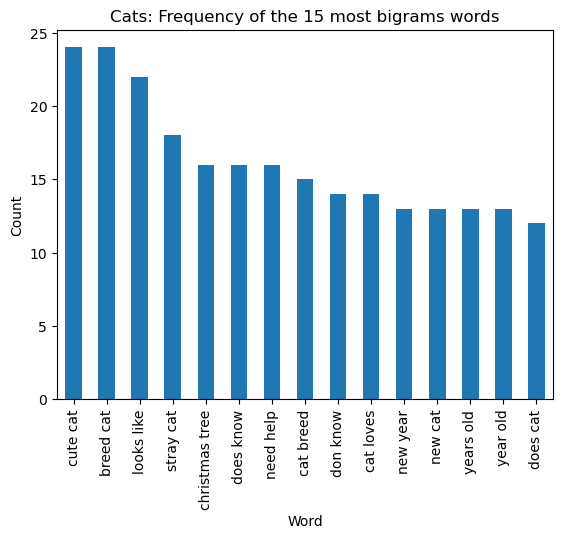

In [64]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most bigrams words')
plt.xlabel('Word')
plt.ylabel('Count');

### Dogs

In [58]:
cvec = CountVectorizer(ngram_range=(2,2), stop_words='english')
cvec.fit(df_dog['title'])
dog_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(dog_cvec.toarray(), columns=cvec.get_feature_names_out())

In [68]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

need help          37
does know          36
breed dog          28
dog breed          27
year old           25
know breed         22
best friend        21
years old          20
cute dog           19
kind dog           19
dog breeds         19
looks like         18
months old         17
month old          16
german shepherd    15
dtype: int64

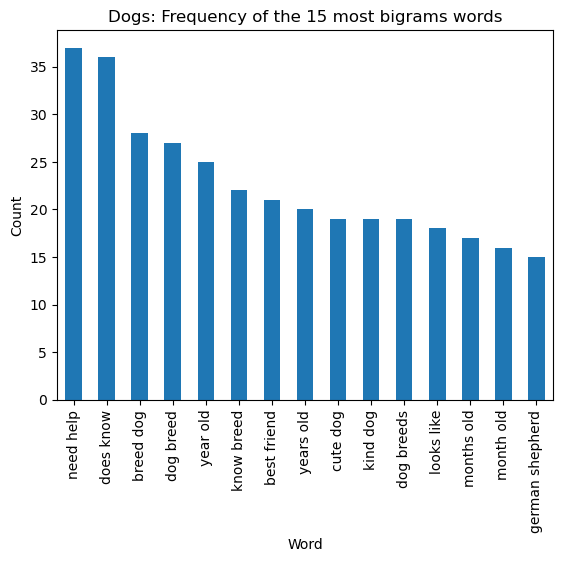

In [65]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most bigrams words')
plt.xlabel('Word')
plt.ylabel('Count');

## Prepare data and Save to csv for next step

In [78]:
# Save cleaned data first
df_cat.to_csv('data/cat_clean.csv')
df_dog.to_csv('data/dog_clean.csv')

Balance data by saving 4000 for each category

In [79]:
# Balance data, change category cat to 1 and DOG to 0
df_nlp = pd.concat([df_cat[:4000], df_dog[:4000]], ignore_index=True).drop(columns='title_length')
df_nlp['subreddit'] = df_nlp['subreddit'].map({'cat':1, 'DOG':0})
df_nlp.to_csv('data/nlp_cat_dog.csv')